# NNIA 18/19 Project 2:  Gradient Descent & Backpropagation

## Deadline: 4. January 2018, 23:59

## 1. Multinomial Logistic Regression and Cross Validation $~$ (12 points)

In this exercise, you will implement a [multinomial logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) model with tensorflow for Fashion-MNIST dataset. Cross Validation will be used to find the best **regularization parameter** $\lambda$ for the L2-regularization term. Fashion-MNIST dataset is similar to the sklearn Digit dataset you used in the Project 1. It contains 60,000 training images and 10,000 testing images. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

![Neural Network](https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png)

Multinomial logistic regression is a probabilistic, linear classifier. It is parametrized by a weight matrix $W$ and a bias vector $b$. Classification is done by projecting an input vector onto a set of hyperplanes, each of which corresponds to a class. The distance from the input to a hyperplane reflects the probability that the input is a member of the corresponding class.

Mathematically, the probability that an input vector $\bf{x} \in \mathbb{R}^p$ is a member of a class $i$ can be written as:
$$P(Y=i|\textbf{x}, W, b) = softmax(W\textbf{x} + b)_i = \frac{e^{W_i\textbf{x} + b_i}}{\sum_j{e^{W_j\textbf{x} + b_j}}}$$
where $W \in \mathbb{R}^{c \times p}$, $b \in \mathbb{R}^c$ and $W_i \in \mathbb{R}^p$.

The model’s prediction $y_{pred}$ is the class whose probability is maximal, specifically:
$$y_{pred} = argmax_iP(Y=i|\textbf{x}, W, b)$$

We use cross-entropy loss with L2 regularization.

### 1.1 Dataset and Normalization

Load **Fashion-MNIST** dataset and normalized it.

In [0]:
import os
import struct
import numpy as np
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_trainval, Y_trainval), (X_test, Y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
X_trainval = np.reshape(X_trainval, (X_trainval.shape[0],  X_trainval.shape[1] *  X_trainval.shape[2]))
print('The X_trainval has the following shape:')
print('Rows: %d, columns: %d' % (X_trainval.shape[0], X_trainval.shape[1]))

The X_trainval has the following shape:
Rows: 60000, columns: 784


In [0]:
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1] *  X_test.shape[2]))
print('The X_test has the following shape:')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

The X_test has the following shape:
Rows: 10000, columns: 784


In [0]:
Y_trainval=tf.keras.utils.to_categorical(Y_trainval)
Y_test=tf.keras.utils.to_categorical(Y_test)
print(Y_trainval.shape,Y_test.shape)

(60000, 10) (10000, 10)


Normalize the data. Subtract the mean and divide by the standard deviation.

In [0]:
def data_normalization(X_trainval, X_test):
    X_trainval_normalised= X_trainval-np.mean(X_trainval,axis=0)/ np.std(X_trainval,axis=0)
    X_test_normalised= X_test-np.mean(X_test,axis=0)/ np.std(X_test,axis=0)
    return X_trainval_normalised, X_test_normalised

In [0]:
# The normalization should be done on X_train and X_test. 
# The normalized data should have the exactly same shape as the original data matrix.

X_trainval, X_test = data_normalization(X_trainval, X_test)
print(X_trainval.shape,X_test.shape)

(60000, 784) (10000, 784)


---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

### 1.2 Define the Computation Graph

In [0]:
# Here the global configuration of this program is 
# defined, which you shouldn't change.

class global_config(object):
    lr = 0.0001  # learning rate
    img_h = 28  # image height
    img_w = 28  # image width
    num_class = 10  # number of classes
    num_epoch = 20  # number of training epochs
    batch_size = 16  # batch size
    K = 3  # K-fold cross validation
    num_train = None  # the number of training data
    lambd = None  # the factor for the L2-regularization

config = global_config()
config.num_train = X_trainval.shape[0]

In [0]:
def train_val_split(X_trainval, Y_trainval, i, K):
    """
    sklearn library is not allowed to use here.
    
    K is the total number of folds and i is the current fold.
    
    Think about how to deal with the case when the number of 
    training data can't be divided by K evenly.
    """
    #TODO: Implement
    #when N cant be divided by K, N%K splits can get an extra data point each?
    #what is i? the most recent fold used for val? or the starting fold of training data?
    N=X_trainval.shape[0]
    n=int(N/K)
    if N%K > 0:
      s=N%K*(n+1)
      split_indicies=np.concatenate((np.arange(0,s,(n+1)),np.arange(s,N+1,n)))
    else:
      split_indicies=np.arange(0,N+1,n)
      
    X_train=np.concatenate((X_trainval[split_indicies[0]:split_indicies[i]],X_trainval[split_indicies[i+1]:]))
    Y_train=np.concatenate((Y_trainval[split_indicies[0]:split_indicies[i]],Y_trainval[split_indicies[i+1]:]))
    
    X_val=X_trainval[split_indicies[i]:split_indicies[i+1]]
    Y_val=Y_trainval[split_indicies[i]:split_indicies[i+1]]
    
    return X_train, X_val, Y_train, Y_val

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [0]:
def shuffle_train_data(X_train, Y_train):
    """called after each epoch"""
    perm = np.random.permutation(len(Y_train))
    Xtr_shuf = X_train[perm]
    Ytr_shuf = Y_train[perm]
    return Xtr_shuf, Ytr_shuf

In [0]:
"""
training
"""
class logistic_regression(object):
    
    def __init__(self, X, Y_gt, config, name):
        """
        :param X: the training batch, which has the shape [batch_size, n_features].
        :param Y_gt: the corresponding ground truth label vector.
        :param config: the hyper-parameters you need for the implementation.
        :param name: the name of this logistic regression model which is used to
                     avoid the naming confict with the help of tf.variable_scope and reuse.
       
        Define the computation graph within the variable_scope here. 
        First define two variables W and b with tf.get_variable.
        Then do the forward pass.
        Then compute the cross entropy loss with tensorflow, don't forget the L2-regularization.
        The Adam optimizer is already given. You shouldn't change it.
        Finally compute the accuracy for one batch
        """
        self.config = config
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            
            #TODO: Define two variables and the forward pass.
            n_features=X.shape[1]
            W=tf.get_variable('weights',shape=[n_features,config.num_class],dtype=tf.float32,initializer=tf.zeros_initializer())
            b=tf.get_variable('biases',shape=[config.num_class],initializer=tf.zeros_initializer())
#             y = tf.nn.softmax(tf.matmul(X, W) + b)
            y = tf.matmul(X, W) + b            
             
            #TODO: Compute the cross entropy loss with L2-regularization.
            self._loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y,labels=Y_gt)+config.lambd*tf.nn.l2_loss(W))
            
            
            # Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent 
            # to update network weights iteratively.
            # It will be introduced in the lecture when talking about the optimization algorithms.
            self._train_step = tf.train.AdamOptimizer(config.lr).minimize(self._loss)
            
            #TODO: Compute the accuracy
            pred = tf.nn.softmax(y)
            correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y_gt,1))
            self._num_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            
    @property
    def train_op(self):
        return self._train_step
    
    @property
    def loss(self):
        return self._loss
    
    @property
    def num_acc(self):
        return self._num_acc

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [0]:
# def get_batch(x,y,config):
#   dataset = tf.data.Dataset.from_tensor_slices((x,y)) 
#   batched_dataset = dataset.batch(config.batch_size)
#   batch_iter = batched_dataset.make_one_shot_iterator()
#   return batch_iter.get_next()

In [0]:
# # unit test for making minibatches
# bx,by=get_batch(X_trainval,Y_trainval,config)
# print(bx,by)

# with tf.Session() as sess:
#   sess.run(tf.global_variables_initializer())
#   batch_X,batch_Y=sess.run([bx,by])
# print(batch_X.shape,batch_Y.shape)

In [0]:
def testing(model, X_test, Y_test, config):
    """ 
    Go through the X_test and use sess.run() to compute the loss and accuracy.
    
    Return the total loss and the accuracy for X_test.
    
    Note that this function will be used for the validation data
    during training and the test data after training.
    """
    num_test = X_test.shape[0]
    total_cost = 0.
    accs = 0.
  
    total_cost, accs = sess.run([model.loss, model.num_acc],feed_dict={X: X_test, Y_gt: Y_test})
    
#     return total_cost / len(Y_test), accs / len(Y_test)
    return total_cost, accs



---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [0]:
def train(model, X_train, X_val, Y_train, Y_val, config):
    """
    Train the model with sess.run().
    
    You should shuffle the data after each epoch and
    evaluate training and validation loss after each epoch.
    
    Return the lists of the training/validation loss and accuracy.
    """
    cost_trains = []
    acc_trains = []
    cost_vals = []
    acc_vals = []
       
    
    for i in range(config.num_epoch):
       #TODO: Implement
        cost_train=0.
        acc_train=0.
        num_batches=int(X_train.shape[0]/config.batch_size)
        start=0
#         print(num_batches)
#         bx,by=get_batch(X_train,Y_train,config)
      
                
        for b in range(num_batches):
            batch_X = X_train[start:start+config.batch_size]
            batch_Y = Y_train[start:start+config.batch_size]
            start=start+config.batch_size
#             batch_X,batch_Y=sess.run([bx,by])
#             print(batch_Y.shape)            
            _, batch_error = sess.run([model.train_op, model.loss],feed_dict={X: batch_X, Y_gt: batch_Y})
           
            batch_acc=sess.run(model.num_acc,feed_dict={X: batch_X, Y_gt: batch_Y})
            cost_train += batch_error
            acc_train += batch_acc
        cost_train /= num_batches
        acc_train /= num_batches
                
        cost_val,acc_val=testing(model, X_test, Y_test, config)
        
        X_train,Y_train=shuffle_train_data(X_train, Y_train)
        X_val,Y_val=shuffle_train_data(X_val, Y_val)
        
        
        cost_trains.append(cost_train)
        acc_trains.append(acc_train)
        print("Epoch: %d :" % (i + 1))
        print("Train Loss: %f" %  cost_train)
        print("Training acc: %f" % acc_train)
        cost_vals.append(cost_val)
        acc_vals.append(acc_val)
        print("Validation Loss: %f" % cost_val)
        print("Validation acc: %f" % acc_val)
    return cost_trains, acc_trains, cost_vals, acc_vals

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

### 1.3 Cross Validation

Implement cross validation to find an optimal value of $\lambda$. The optimal hyper-parameters should be determined by the validation accuracy. The test set should only be used in the very end after all other processing, e.g. hyper-parameter choosing.

In [0]:
"""
Initialization
"""
# Use cross validation to choose the best lambda for the L2-regularization from the list below
lambda_list = [100, 1, 0.1]


X = tf.placeholder(tf.float32, [None, config.img_h * config.img_w])
Y_gt = tf.placeholder(tf.float32, [None, config.num_class ])

for lambd in lambda_list:
    val_loss_list = []
    config.lambd = lambd
    print("lambda is %f" % lambd)
    
    for i in range(config.K):
        # Prepare the training and validation data
        X_train, X_val, Y_train, Y_val = train_val_split(X_trainval, Y_trainval, i, config.K)
        
        # For each lambda and K, we build a new model and train it from scratch
        model = logistic_regression(X, Y_gt, config, name=str(lambd)+'_'+str(config.K))
        
        with tf.Session() as sess:
            
            # Initialize the variables of the model
            sess.run(tf.global_variables_initializer())
            
            # Train the model
            cost_trains, acc_trains, cost_vals, acc_vals = train(model, X_train, X_val, Y_train, Y_val, config)
            
        val_loss_list.append(cost_vals[-1])
        
    print("The validation loss for lambda %f is %f" % (lambd, np.mean(val_loss_list)))
    

lambda is 100.000000
Epoch: 1 :
Train Loss: 1.559821
Training acc: 0.770900
Validation Loss: 3.020351
Validation acc: 0.644600
Epoch: 2 :
Train Loss: 1.514320
Training acc: 0.781175
Validation Loss: 1.130508
Validation acc: 0.790700
Epoch: 3 :
Train Loss: 1.596525
Training acc: 0.778700
Validation Loss: 1.936035
Validation acc: 0.698000
Epoch: 4 :
Train Loss: 1.597124
Training acc: 0.776025
Validation Loss: 1.704520
Validation acc: 0.730100
Epoch: 5 :
Train Loss: 1.581060
Training acc: 0.780025
Validation Loss: 1.281757
Validation acc: 0.772700
Epoch: 6 :
Train Loss: 1.540450
Training acc: 0.781000
Validation Loss: 3.136189
Validation acc: 0.722300
Epoch: 7 :
Train Loss: 1.610114
Training acc: 0.777925
Validation Loss: 1.882398
Validation acc: 0.704000
Epoch: 8 :
Train Loss: 1.553679
Training acc: 0.780825
Validation Loss: 2.577926
Validation acc: 0.679200
Epoch: 9 :
Train Loss: 1.636597
Training acc: 0.777975
Validation Loss: 1.791513
Validation acc: 0.734300
Epoch: 10 :
Train Loss: 1

### 1.4 Combine Train and Validation data.

Use the hyper-parameters you choose from the cross validation to re-train the model.

In [0]:
config.lambd = 100  #TODO: Choose the best lambda
model = logistic_regression(X, Y_gt, config, name='trainval')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_trains, acc_trains, cost_tests, acc_tests = train(model, X_trainval, X_test, Y_trainval, Y_test, config)

print("The final test acc is %f" % acc_tests[-1])

Epoch: 1 :
Train Loss: 1.532274
Training acc: 0.773750
Validation Loss: 3.722109
Validation acc: 0.650000
Epoch: 2 :
Train Loss: 1.580752
Training acc: 0.778033
Validation Loss: 1.688266
Validation acc: 0.739900
Epoch: 3 :
Train Loss: 1.576943
Training acc: 0.777783
Validation Loss: 1.437472
Validation acc: 0.756100
Epoch: 4 :
Train Loss: 1.578922
Training acc: 0.778767
Validation Loss: 1.484006
Validation acc: 0.742100
Epoch: 5 :
Train Loss: 1.547667
Training acc: 0.779417
Validation Loss: 1.836202
Validation acc: 0.701900
Epoch: 6 :
Train Loss: 1.611927
Training acc: 0.775517
Validation Loss: 1.457206
Validation acc: 0.741500
Epoch: 7 :
Train Loss: 1.552892
Training acc: 0.778367
Validation Loss: 1.384164
Validation acc: 0.748700
Epoch: 8 :
Train Loss: 1.606829
Training acc: 0.777267
Validation Loss: 1.255086
Validation acc: 0.773700
Epoch: 9 :
Train Loss: 1.582176
Training acc: 0.777767
Validation Loss: 1.587537
Validation acc: 0.744600
Epoch: 10 :
Train Loss: 1.573319
Training acc:

---
**Points:** $0.0$ of $0.5$
**Comments:** None

---

### 1.5 Questions

1. What is the impact of k in k-fold cross validation?

2. What will happen to the training if you change the $\lambda$ for L2-regularization?

3. Why do we perform the gradient descent on a batch of the data rather than all of the data?

4. Why does the loss increase, when the learning rate is too large?

5. Do we apply L2-regularization for the bias $b$?

*Answer:* 
1. In K-fold validation, resampling strategy, K, is the number of groups we split the training samples into. The value of K should be wisely chosen such that it fits the bias-variance tradeoff. (With lower and Higher K respectively).

2. As $\lambda$ is inversely proportional to he norm of weights (w), increasing $\lambda$ decreases w and hence penalizes large parameters. By adjusting $\lambda$ we can have a better control on data fitting and hence avoid over-fittimg and under-fitting suitably. 

3.Gradient descent on batch of data allows memory efficient training schedules with less training samples in memory. Also, the model update frequency allows for a more robust convergence, avoiding local minima.

4. If learning rate is too large, gradient descent might overshoot the minimum and will not converge, also, might diverge and hence increasing the loss.

5. No, we usually skip the bias b during L2-regularization. Penalization of the bias(intercept) would make the procedure depend on the origin chosen for Y_Pred; that is, adding a constant c to each of the targets would not simply result in a shift of the predictions by the same amount c. 

---
**Points:** $0.0$ of $2.5$
**Comments:** None

---

## 2. Getting to know Back-Propagation in details $~$ (18 points)

In the following exercise you would build a **feed-forward network** from scratch using **only** Numpy. For this, you also have to implement **Back-propagation** in python. Additionally, this network should have the option of **L2 regularization** enabled within it.

**Before you start**: In this exercise you will implement a single hidden layer feedforward neural network. In case you are unfamiliar with the terminology and notation used here, please consult chapter 6 of the Deep Learning Book before you proceed.

Generally speaking, a feedword neural network with a single hidden layer can be represented by the following function $$ f(x;\theta) = f^{(2)}(f^{(1)}(f^{(0)}(x)))$$ where $f^{(0)}(x)$ is the input layer, $f^{(1)}(.)$ is the so called hidden layer, and $f^{(2)}(.)$ is the ouput layer of the network. $\theta$ represents the parameters of the network whose values will be learned during the training phase.

The network that you will implement in this exercise has the following layers:
* $f^{(0)}(x) = \mathbf{X}$, with $\mathbf{X} \in \mathbb{R}^{b,p}$ where $b$ is the batch size and $p$ is the number of features.
* $f^{(1)}(.) = \sigma(\mathbf{X} \mathbf{W_1}+b_1)$, with $\mathbf{X} \in \mathbb{R}^{b, p}$, $\mathbf{W_1} \in \mathbb{R}^{p,u_1}$, $\textbf{b}_1 \in \mathbb{R}^{u_1}$ where $u_1$ is the number of **hidden units**. Additonally, $\sigma(x) = \frac{1}{1 + \exp{(-x})}$ is the **sigmoid** function.
* $f^{(2)}(.) = softmax(\mathbf{X} \mathbf{W_2}+b_2)$, with $\mathbf{X} \in \mathbb{R}^{b, u_1}$, $\mathbf{W_2} \in \mathbb{R}^{u_1,u_2}$, $\textbf{b}_2 \in \mathbb{R}^{u_2}$ where $u_2$ is the number of **output classes** in this particular layer.

Note that both, $\sigma(x)$ are applied **elementwise**. Further, the addition with the bias vector is also applied **elementwise** to each row of the matrix $\mathbf{X} \mathbf{W}$.

In [0]:
import numpy as np


class Fully_connected_Neural_Network(object):
    """ Fully-connected neural network with one hidden layer.

    Parameters
    ------------
    n_output : int
        Number of class labels.
        
    n_features : int
        Number of input features.
        
    n_hidden : int
        Number of hidden units.
        
    l2 : float
        regularization parameter
        0 means no regularization
        
    epochs : int
        One Epoch is when the entire dataset is passed forward and backward through the neural network only once.
        
    lr : float
        Learning rate.
        
    batchsize : int
        Total number of training examples present in a single batch.
        

    Attributes
    -----------
    w1 : array, shape = [n_features, n_hidden_units]
        Weight matrix for input layer -> hidden layer.
    w2 : array, shape = [n_hidden_units, n_output_units]
        Weight matrix for hidden layer -> output layer.
    b1 : array, shape = [n_hidden_units, ]
        Bias for input layer-> hidden layer.
    b2 : array, shape = [n_output_units, ]
        Bias for hidden layer -> output layer.

    """
    # Points: 2.0
    def __init__(self, n_output, n_features, n_hidden=30,
                 l2=0.0, epochs=50, lr=0.001, batchsize=1):
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.lr = lr
        self.batchsize = batchsize
        #TODO Initialize weights and biases with np.random.uniform or np.random.normal and specify the shape
        self.w1 = np.random.uniform(-1, 1, (self.n_features,self.n_hidden))
        self.w2 = np.random.uniform(-1, 1, (self.n_hidden,self.n_output))
        
        #self.w1 = np.random.uniform(low=0.0, high=1.0, size=self.n_features*self.n_hidden)
        #self.w1 = self.w1.reshape(self.n_features,self.n_hidden)
        #self.w2 = np.random.uniform(low=0.0, high=1.0, size=self.n_hidden*self.n_output)
        #self.w2 = self.w2.reshape(self.n_hidden,self.n_output)
        
        self.b1 = np.random.uniform(low=0.0, high=1.0, size=self.n_hidden)
        self.b2 = np.random.uniform(low=0.0, high=1.0, size=self.n_output,)
        #print(self.w1)
        
        #return w1,w2,b1,b2

        
    # Points: 0.5
    def sigmoid(self, z):
        """Compute sigmoid function"""
        #TODO Implement
        sigm = 1./(1.+np.exp(-z))
        return sigm
        


    # Points: 0.5
    def sigmoid_gradient(self, z):
        """Compute gradient of the sigmoid function"""
        #TODO Implement
        
        sigm_grad = self.sigmoid(z)*(1. - self.sigmoid(z))
        return sigm_grad

    
    # Points: 1.0
    def softmax(self, z):
        """Compute softmax function.
        Implement a stable version which 
        takes care of overflow and underflow.
        """        
        #TODO Implement
        x = np.max(z,axis=1)
        x = x[:, np.newaxis]
        num = np.exp(z-x)
        denom = np.sum(num, axis=1)
        denom = denom[:, np.newaxis]
        stable_softmax = num/denom
#         print('computed softmax')
        return stable_softmax

        
    # Points: 2.0
    def forward(self, X):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            
        Returns
        ----------
        z2 : array,
            Input of the hidden layer.
        a2 : array,
            Output of the hidden layer.
        z3 : array,
            Input of the output layer.
        a3 : array,
            Output of the output layer.

        """
        # TODO Implement
        
        
        
       #z2 = np.sum(np.matmul(X,self.w1),self.b1)
        z2 = np.matmul(X,self.w1) + self.b1
        a2 = self.sigmoid(z2)
       #z3 = np.sum(np.matmul(a2,self.w2)+self.b2)
        z3 = np.matmul(a2,self.w2) + self.b2
        a3 = self.softmax(z3)
#         print('completed fprop')
        
        
        return z2, a2, z3, a3
        
    # Points: 0.5
    def L2_regularization(self, lambd):
        """Implement L2-regularization loss"""
        #TODO Implement
        l2_reg = (np.sum(np.square(self.w1)) + np.sum(np.square(self.w2)))*(lambd/(2*self.batchsize))
        return l2_reg
        
       
        
        
    # Points: 2.0
    def loss(self, y_enc, output, epsilon=1e-12):
        """Implement total loss.

        Parameters
        ----------
        y_enc : array, one-hot encoded labels.
        
        output : array, output of the output layer

        Returns
        ---------
        cost : float, total loss.

        """
        #TODO Implement
        np.place(output,output == 0, epsilon)
       #cost = - np.mean(np.sum(y_enc * np.log(output),axis = 1))
        cost = - np.mean(np.sum(y_enc * np.log(output),axis = 1))+self.L2_regularization(epsilon)
        #logprobs = np.multiply(y_enc, np.log(output)) + np.multiply((1 - y_enc), np.log(1 - output))
        #cross_entropy_cost = (-1.0/self.n_output) * np.sum(logprobs) 
        #cost = cross_entropy_cost+self.L2_regularization(self.l2)
        
        return cost
        
        
    # Points: 4.0
    def compute_gradient(self, X, a2, a3, z2, y_enc):
        """ Compute gradient using backpropagation.

        Parameters
        ------------
        X : array, Input.
        a2 : array, output of the hidden layer.
        a3 : array, output of the output layer.
        z2 : array, input of the hidden layer.
        y_enc : array, one-hot encoded labels.

        Returns
        ---------
        grad1 : array, Gradient of the weight matrix w1.
        grad2 : array, Gradient of the weight matrix w2.
        grad3 : array, Gradient of the bias vector b1.
        grad4 : array, Gradient of the bias vector b2.
        """
        #TODO Implement
        m = self.batchsize
       # print(m)
        
        #dz3 = a3 - y_enc
       #grad1 = np.dot(np.transpose(X),(np.dot((a3-y_enc),np.transpose(self.w2)) * self.sigmoid_gradient(z2)))
        #grad3 = np.dot((a3-y_enc),np.transpose(self.w2)) * self.sigmoid_gradient(z2) 
        
        grad1 = np.dot(np.transpose(X),(np.dot((a3-y_enc),np.transpose(self.w2)) * self.sigmoid_gradient(z2))) + (self.l2/m)*self.w1 #dw1
        grad3 = np.dot((a3-y_enc),np.transpose(self.w2)) * self.sigmoid_gradient(z2)  #db1
        grad2 = np.dot(np.transpose(a2),(a3 - y_enc)) + (self.l2/m)*self.w2  #dw2
        grad4 = a3 - y_enc #db2
        
        #dw2 = (1.0/m) * np.matmul(np.transpose(a2), dz3) ## add the regularization term ? #changed to a3
        #db2 = (1.0/m) * np.sum(dz3, axis=1, keepdims=True)
    
        #dz2 = np.matmul(dz3, np.transpose(self.w2)) * (1 - np.power(a2, 2))
        #dw1 = (1.0/m) * np.matmul(np.transpose(X),dz2) ## add the regularization ? 
        #db1 = (1.0/m) * np.sum(dz2, axis=1, keepdims=True)
        
        #grad1 = dw1
        #grad2 = dw2
        #grad3 = db1
        #grad4 = db2 
#         print('computed grads')

        return grad1, grad2, grad3, grad4
        
    # Points: 1.0
    def inference(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, Input.

        Returns:
        ----------
        y_pred : array, Predicted labels.

        """
        # TODO Implement
        z2, a2, z3, a3 = self.forward(X)
       # y_pred = a3 > 0.5
        if a3 > 0.5 :
          return 1
        else:
          return 0
        
       
       # return y_pred
    
    
    def shuffle_train_data(self, X, Y):
        """called after each epoch"""
        perm = np.random.permutation(Y.shape[0])
        X_shuf = X[perm]
        Y_shuf = Y[perm]
        return X_shuf, Y_shuf
      
    
    
    # Points: 2.0
    def train(self, X_train, Y_train, verbose=False):
        """ Fit the model.

        Parameters
        -----------
        X : array, Input.
        y : array, Ground truth class labels.
        verbose : bool, Print the training progress

        Returns:
        ----------
        self

        """
        #TODO Initialization
        self.cost_ = []
        self.batch_cost_list = []
        

        for i in range(self.epochs):
        
            if verbose:
                print('\nEpoch: %d/%d' % (i+1, self.epochs))


                # feedforward and loss computation
                num_batches=int(X_train.shape[0]/self.batchsize)
                #print('fprop')
                start=0
                cost_train=0.
                
                
                for b in range(num_batches):
                  #print("batch_num",b)
                  batch_X = X_train[start:start+self.batchsize]
                  batch_Y = Y_train[start:start+self.batchsize]
                  start=start+self.batchsize
                  z2, a2, z3, a3 = self.forward(batch_X)
                  batch_cost =  self.loss(batch_Y, a3, self.l2)
                  self.batch_cost_list.append(batch_cost)
                  cost_train =  cost_train + batch_cost
                  
                  #print('grads')
                  grad1, grad2, grad3, grad4 = self.compute_gradient(batch_X, a2, a3, z2, batch_Y)
                  #Updating weights
                  
                  self.w1 = self.w1 - (self.lr*grad1)
                  self.b1 = self.b1 - (self.lr*grad3).sum(axis=0)
                  self.w2 = self.w2 - (self.lr*grad2)
                  self.b2 = self.b2 - (self.lr*grad4).sum(axis=0)
                  
                  
                cost = cost_train/num_batches
                print(cost)
                self.cost_.append(cost)

                #compute gradient via backpropagation and update the weights
                #print('grads')
                #grad1, grad2, grad3, grad4 = self.compute_gradient(X_train, a2, a3, z2, Y_train)

        return self
      
      
      ##evaluation function for calculating the train and test accuracy
    def evaluation (self, X, Y):
      
        
      num_batches=int(X.shape[0]/self.batchsize)
      start=0
     # y_pred_list = []
      acc_list = []
      for b in range(num_batches):
        counter = 0
        batch_Y_list = []
        a3_list = []
        batch_X = X[start:start+self.batchsize]
        batch_Y = Y[start:start+self.batchsize]
        start=start+self.batchsize
        z2, a2, z3, a3 = self.forward(batch_X)
        a3_list.append(a3.argmax(1))
        batch_Y_list.append(batch_Y.argmax(1))
        #count = sum(np.equal(a3_list,batch_Y_list))
       # print(a3_list.shape,batch_Y_list.shape)
        #counter = np.sum(a3_list == batch_Y) ##element wise comparison
        #print(count)
        #print(len(a3))
       # y_pred_list.append(a3-batch_Y)
       # counter = np.count_nonzero(y_pred_list)
        #print
       # print(counter)
        acc_list.append(np.mean(np.equal(a3_list,batch_Y_list)))
      #acc_list = y_pred_list - Y
      return np.mean(acc_list)
        
        
        

---
**Points:** $0.0$ of $15.5$
**Comments:** None

---

In [0]:
nn = Fully_connected_Neural_Network(n_output=10, 
                                    n_features=X_trainval.shape[1], 
                                    n_hidden=50, 
                                    l2=0.1, 
                                    epochs=1000, 
                                    lr=0.001,
                                    batchsize=1200) #batchsize being changed from 50 to 1000

In [0]:
nn_params = nn.train(X_trainval, Y_trainval, verbose=True)


Epoch: 1/1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in exp


2.2134505677501664

Epoch: 2/1000
1.6974156923825856

Epoch: 3/1000
1.6127755566179176

Epoch: 4/1000
1.5655986334963163

Epoch: 5/1000
1.580213384632455

Epoch: 6/1000
1.541096085856363

Epoch: 7/1000
1.5809679391230502

Epoch: 8/1000
1.513561253769968

Epoch: 9/1000
1.585140597094572

Epoch: 10/1000
1.5986663785078732

Epoch: 11/1000
1.5923143295146107

Epoch: 12/1000
1.5668860366965063

Epoch: 13/1000
1.5216383292743765

Epoch: 14/1000
1.5155143027150906

Epoch: 15/1000
1.4922422327499085

Epoch: 16/1000
1.5820368401374896

Epoch: 17/1000
1.6701397872790704

Epoch: 18/1000
1.606686390753071

Epoch: 19/1000
1.5920213191362016

Epoch: 20/1000
1.6163507265775885

Epoch: 21/1000
1.6621432832070124

Epoch: 22/1000
1.7767749107502109

Epoch: 23/1000
1.6772577301959677

Epoch: 24/1000
1.7172775946601269

Epoch: 25/1000
1.622584576950138

Epoch: 26/1000
1.6357057565985673

Epoch: 27/1000
1.5588101626872537

Epoch: 28/1000
1.5680603361544518

Epoch: 29/1000
1.5953135640744514

Epoch: 30/1000

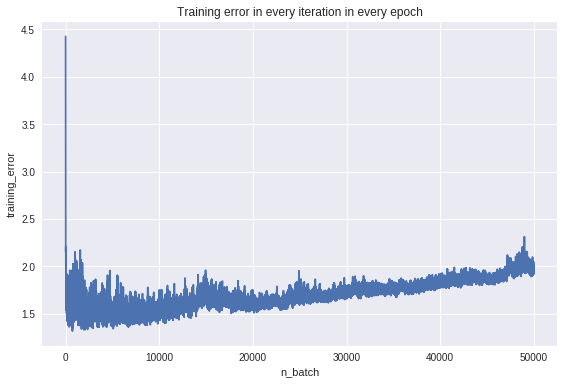

In [0]:
import matplotlib.pyplot as plt

# Plot the training error for every iteration
# in every epoch

# TODO Implement
plt.plot(nn_params.batch_cost_list)
plt.xlabel("n_batch")
plt.ylabel("training_error")
plt.title("Training error in every iteration in every epoch")
plt.tight_layout()
plt.show()

---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

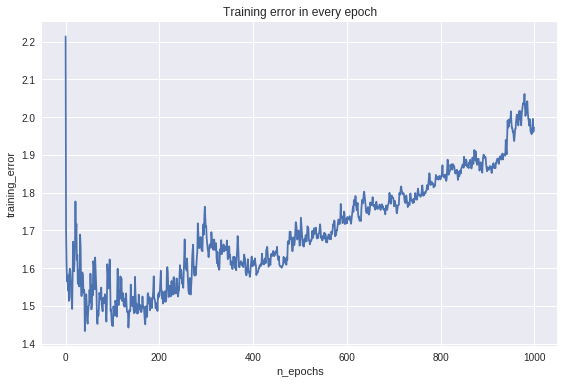

In [0]:
# Plot the training error in every epoch
# TODO Implement
plt.plot(nn_params.cost_)
plt.xlabel("n_epochs")
plt.ylabel("training_error")
plt.title("Training error in every epoch")
plt.tight_layout()
plt.show()

---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

In [0]:
# Compute Training Accuracy
# TODO Implement
acc_training = nn.evaluation(X_trainval, Y_trainval)


print('Training accuracy: %.2f%%' % (acc_training * 100))


# Compute Test Accuracy
# TODO Implement
acc_testing = nn.evaluation(X_test, Y_test)
print('Test accuracy: %.2f%%' % (acc_testing * 100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in exp


Training accuracy: 77.82%
Test accuracy: 76.53%


---
**Points:** $0.0$ of $0.5$
**Comments:** None

---

## Submission instructions
You should provide a single Jupyter notebook (.ipynb file) as the solution. Put the names and student ids of your team members below. **Make sure to submit only 1 solution to only 1 tutor.**

- Jane Doe, 123456
- Jane Doe, 123456
- Jane Doe, 123456

## Points: 0.0 of 30.0 points